# Hackathon in AI for Sustainability - University of Hull, 28th March - 1st April 2022. 
## Project 2: Monopile fatigue estimation from nonlinear waves using deep learning.
# **** MODIFIED CODE - TESTING RNN MODEL ****

---




Welcome and thank you for participating in this Hackathon Project! 

This project is based around the development of a machine learning model (meta-model) to predict the damage fraction (D) of an example offshore wind turbine monopile. Here, the damage fraction defines the amount of damage (loss of structural integrity) the monopile incurs over a give period (1-hour) and is dependent of the following 'environmental' or 'metocean' (wind and wave) variables: 

- Significant wave height, Hs (m)
- Peak wave period, Tp (s)
- Mean hub height wind speed, Uw (m/s)

and the operational state of the turbine, State (-); whereby '1' is an operational turbine, '2' is a parked turbine.

This following example code is separated into two parts:
- Part 1: Development of a meta-model to predict monopile damage fraction (Example code based on convolutional neural networks)
- Part 2: Calculation of estimated damage from developed meta-model for an example dataset

The aim of this project is to:

1. Benchmark the performance of a variety of different neural networks (e.g. recurrent neural networks, transformer networks, convolutional neural networks) to establish which family of deep learning model is the most 
suitable to this task and project
2. Evaluate whether a reliable meta-model can be developed by using fewer inputs data points (i.e. randomly selecting less training data). 


Finally, a third dataset is available for testing the model. 13 additional damage fraction values have been numerically simulated based on 'data lumping' methods (introduced in project overview presentation) - these can be used to provide a secondary validation of any meta-models by comparing the model outputs for these loading case inputs, and the model predicted damage fraction value.


The code provided below can be run directly here. If you wish to edit/build on this code, please made a copy to your own Google Drive along with the required datasets in the root folder "HullUniversity_AI_Sustanability_Hackathon_Project2".





### Part 1: Development of a meta-model to predict monopile damage fraction

### (Example code based on convolutioal neural networks)

Numerical simulations and calculations have been conducted based on example turbine, and provides the damage fraction for a myriad of combinations of the variables above, this is stored in the file named "FNL_Damage_Hackathon.csv" located in the root folder. 

This forms the training (and test) dataset to enable development of deep learning based model to predict the damage fraction for any given input metocean condition.

First, connect to your google drive where you have saved the input datafiles.






In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Import required packages.

In [ ]:
!pip install xgboost

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

print("TensorFlow version:", tf.__version__)
print(keras.__version__)

ModuleNotFoundError: ignored

Load training dataset and remove any NaN values and outliers (threshold not justified here). 




In [ ]:
data=pd.read_csv('gdrive/My Drive/HullUniversity_AI_Sustanability_Hackathon_Project2/FNL_Damage_Hackathon.csv') # correct file location as required
data = data.dropna() # remove NaN data entries

valid_values = abs(data['D'] < 0.0030) # remove outliers
data = data[valid_values]


View imported dataset, which includes the following variables per column
- Tp= Peak wave period (s)
- Hs = Significant wave height (m)
- Uw = Mean wind speed at turbine hub height (m/s)
- Op = Turbine opperatinal state, whereby 1 = opperational, and 2 = parked
- D = Hourly monopile damage fraction associated with the above variables. 



In [ ]:
data.head() # display data

,Tp,Hs,Uw,Op,D
0,2.0,0.004385,1,1,1.760000e-09
2,2.0,0.004385,2,1,1.500000e-06
3,2.0,0.004385,2,2,5.710000e-10
4,2.0,0.004385,3,1,1.900000e-07
5,2.0,0.004385,3,2,4.530000e-10


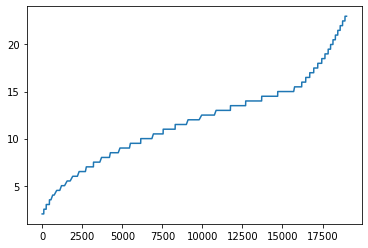

In [ ]:
data["Tp"].plot()

Select training inputs data, and remove any unwanted columns from inputs dataset.


In [ ]:
y=data[['D']]
x=data.drop(columns=['D'])
x["Op"] = x["Op"] -1 
x.head()


(16985, 4)


Create training and test datasets. Set test:train ratio (80:20 split used in this example)

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2, random_state=42)
print(x_train.shape)
print(y_train.shape)

(13588, 4)
(13588, 1)


Normalise the input data, and reshape for input into convolutional neural network.

In [ ]:
FNL_output_scaler = MinMaxScaler(feature_range=(0, 1), copy=False) # create scaler
FNL_output_scaler.fit(y_train)
y_train=FNL_output_scaler.transform(y_train)
y_test=FNL_output_scaler.transform(y_test)
FNL_input_scaler = MinMaxScaler(feature_range=(0, 1), copy=False) # create scaler
FNL_input_scaler.fit(x_train)
x_train=FNL_input_scaler.transform(x_train)
x_test=FNL_input_scaler.transform(x_test)

#x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
#x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)


Create XGBoost model

In [ ]:
xgb_parameters = {"objective ":"reg:squarederror","seed":42}
#x_train_dmatrix = xgb.DMatrix(x_train,label=y_train)
num_rounds = 1000
xgb_model = xgb.XGBRegressor()
xgb_model.fit(x_train, y_train)

[10:54:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

Fit (Train) model

[0.02600575 0.06832749 0.36238745 0.54327935]


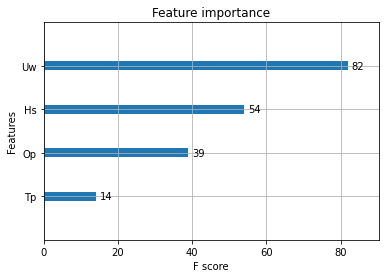

In [ ]:
print(xgb_model.feature_importances_)
xgb.plot_importance(xgb_model)
plt.show()

In [ ]:
x_test_dmatrix = xgb.DMatrix(x_test,label=y_test)
preds = xgb_model.predict(x_test)
unique_elements, counts_elements = np.unique(preds, return_counts=True)
print(unique_elements)
print(counts_elements)
error = mean_squared_error(y_test,preds)
print("{}".format(error))

[-1.39474869e-05 -1.09672546e-05 -8.28504562e-06 -6.07967377e-06
 -5.36441803e-06 -4.76837158e-06 -3.45706940e-06 -1.78813934e-06
 -3.57627869e-07  8.94069672e-08  1.07288361e-06  2.92062759e-06
  3.12924385e-06  5.72204590e-06  6.49690628e-06  6.70552254e-06
  7.92741776e-06  8.55326653e-06  1.02221966e-05  1.10566616e-05
  1.13844872e-05  1.17719173e-05  1.21295452e-05  1.29938126e-05
  1.35600567e-05  1.43051147e-05  1.56462193e-05  1.59442425e-05
  1.66893005e-05  1.70171261e-05  1.71363354e-05  1.74045563e-05
  1.84774399e-05  1.86264515e-05  1.99675560e-05  2.05338001e-05
  2.15768814e-05  2.47657299e-05  2.91168690e-05  2.91466713e-05
  2.96831131e-05  3.01599503e-05  3.01897526e-05  3.04281712e-05
  3.18586826e-05  3.19480896e-05  3.25143337e-05  3.53753567e-05
  3.69548798e-05  3.75211239e-05  3.93390656e-05  3.95774841e-05
  4.00841236e-05  4.06503677e-05  4.21106815e-05  4.21702862e-05
  4.34219837e-05  4.48226929e-05  4.49717045e-05  4.55379486e-05
  4.61339951e-05  4.71770

Predict model results based on test data inputs

In [ ]:
print(xgb_model.get_split_value_histogram("Hs"))

   SplitValue  Count
0    3.251226    1.0
1    3.817414    2.0
2    4.949792    4.0
3    6.082170    4.0
4    7.214548    2.0
5    8.346926    2.0
6    8.913114    2.0
7    9.479303    5.0


Plot results between model predicted damage and simulated damage. 

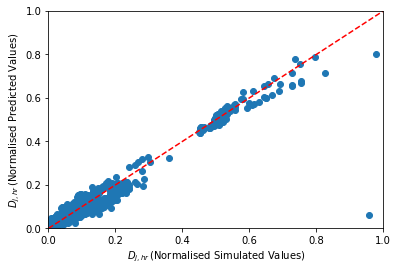

In [ ]:
plt.figure(1)
plt.rcParams["mathtext.default"]
plt.scatter(y_test,y_test_pred) # plot predicted v origonal
plt.xlabel(r'$D_{j,hr} \/$' '(Normalised Simulated Values)')
plt.ylabel(r'$D_{j,hr} \/$' '(Normalised Predicted Values)')
lims = [0, 1]
plt.xlim(lims)
plt.ylim(lims)

xplot = np.linspace(0,1,100)
yplot = xplot
plt.plot(xplot, yplot, '--r')

Plot result residuals, and calculate r-squared score

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


0.9611552464166416

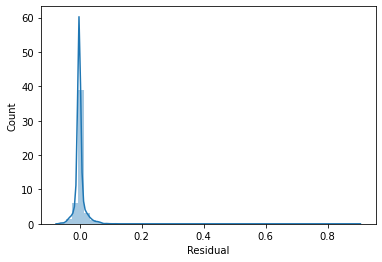

In [ ]:
import seaborn as sns
residuals = y_test - y_test_pred
sns.distplot(residuals)
plt.xlabel(r'Residual')
plt.ylabel(r'Count')

plt.savefig('FNL_cnn_model_residuals_23022022_2.png',dpi=300)

from sklearn.metrics import r2_score
r2_score(y_test, y_test_pred)  

Plot model loss and accuracy

dict_keys(['loss', 'mean_absolute_percentage_error', 'val_loss', 'val_mean_absolute_percentage_error'])


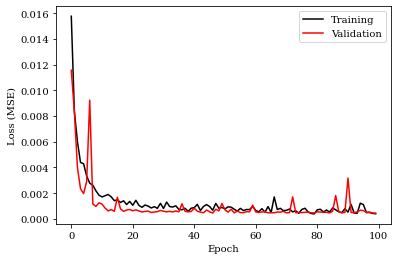

In [ ]:
print(history.history.keys())

from cycler import cycler

plt.figure(1)
plt.rcParams['axes.prop_cycle'] = cycler(color=['k', 'r', 'b', 'g'])
plt.rcParams['font.family'] = 'Serif'

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.savefig('FNL_cnn_loss_23022022_2.png',dpi=300)

plt.show()

Save model

In [ ]:
model.save('FNL_Damage_CNN_model_hackathon')
model.save('FNL_Damage_CNN_model_hackathon.h5')

#from sklearn.externals import joblib
#joblib.dump(FNL_output_scaler, "FNL_output_scaler") 
#joblib.dump(FNL_input_scaler, "FNL_input_scaler") 

INFO:tensorflow:Assets written to: FNL_Damage_CNN_model_hackathon/assets


### Part 2: Calculation of estimated damage from developed meta-model for an example dataset

Now that we have developed a meta-model to estimate monopile damage based on input data, we can input measured data from the North Sea at the FINO1 research platform (www.fino1.de). A data set named "fino1_hourly_aug2019_aug2020.csv" is provide in the root folder, containing hourly input data, and whether the turbine would be parked or operational (a known factor based on the wind speed). 

Firstly, import this datasets.



In [ ]:
data_hourly=pd.read_csv('gdrive/My Drive/HullUniversity_AI_Sustanability_Hackathon_Project2/fino1_hourly_aug2019_aug2020.csv')
data_hourly["Op"] = data_hourly["Op"] -1 
print(data_hourly.columns)
data_hourly.head()

Index(['Tp', 'Hs', 'Uw', 'Op'], dtype='object')


,Tp,Hs,Uw,Op
0,4.32,0.95,7.915000,0
1,5.26,1.00,6.878333,0
2,4.98,0.95,7.683333,0
3,5.57,1.03,8.198333,0
4,5.49,1.04,7.060000,0


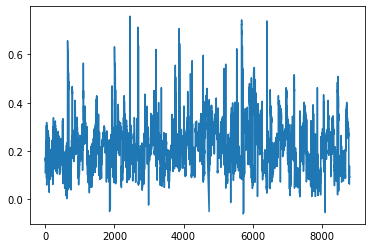

In [ ]:
data_hourly["Tp"].plot()

Given that the inputs to out model were scaled, we need to apply the same scaling transfer to the measured data we are going to apply to the meta-model. Also, as during model development, we need to reshape the dataset.

In [ ]:
data_hourly=FNL_input_scaler.transform(data_hourly)
#data_hourly_input = data_hourly.reshape(data_hourly.shape[0], data_hourly.shape[1], 1)
#print(data_hourly_input.shape)

We can now input our measured dataset into the model to determine the corresponding damage value calculated by the meta-model.

In [ ]:
data_hourly = pd.DataFrame(data_hourly,columns=['Tp', 'Hs', 'Uw', 'Op'])
D_hourly_Pred=xgb_model.predict(data_hourly)

Given that the output damage values form the meta-model are normalised, we must apply the inverse transformation function.




In [ ]:
D_hourly_Pred_true=FNL_output_scaler.inverse_transform(D_hourly_Pred.reshape(-1,1))
print(D_hourly_Pred_true)
print(type(D_hourly_Pred_true))
unique_elements, counts_elements = np.unique(D_hourly_Pred_true, return_counts=True)
print(unique_elements)
print(counts_elements)

[[1.0085389e-07]
 [1.0085389e-07]
 [1.0085389e-07]
 ...
 [1.0085389e-07]
 [1.0085389e-07]
 [1.0085389e-07]]
<class 'numpy.ndarray'>
[5.8630079e-08 1.0085389e-07]
[ 932 7876]


We now have a series of damage fraction values corresponding to measured conditions, based on the model predicts. These values can now be used to estiamte the damage accumulated over the one year period.



# *End of example*